# Introduction

In this notebook, we create a mock HI signal, along with system noise and a calibration measurement,
that will allow us to explore analysis approaches for calibration.
We begin with a quick review of the origin of these measurements.

## Brightness Temperature

__Specific Intensity__, $I_\nu$, is how we trace radiation along a ray. It has units of energy per second per area per Hz per steradian:
\begin{equation}
\left[I_\nu\right] = \frac{\rm ergs}{\rm s\cdot cm^2 \cdot Hz \cdot sr}.
\end{equation}
Sources of radiation contribute to $I_\nu$, which is gathered over the beam of the telescope ($\Omega$, in steradians), over the area of the aperture ($A$, in cm$^2$), and over the bandwidth of the receiver ($B$, in Hz)
to give us a power, $P=I_\nu\cdot\Omega\cdot A\cdot B$.

For an optically thick blackbody that absorbs and receives radiation perfectly to achieve thermal equilibrium, 
the specific intensity asymptotes (at high optical thickness) to the Planck function,
\begin{equation}
B_\nu = \frac{2h\nu^3}{c^2}\frac1{e^\frac{h\nu}{kT} - 1}.
\end{equation}

Particularly in radio astronomy where photon energies $E=h\nu$ are much smaller than any relevant
thermal energy $E=kT$ (the Rayleigh-Jeans Tail), this function simplifies to
\begin{equation}
B_\nu\approx\frac{2kT}{\lambda^2}.
\end{equation}

This Rayleigh-Jeans approximation of the Planck function is then taken to be the *definition* of a brightness
temperature $T_b$ that represents a measured specific intensity
\begin{equation}
T_b\equiv I_\nu \frac{\lambda^2}{2 k}.
\end{equation}
This __brightness temperature__ represents the thermal temperature an optically thick blackbody would need
to have to produce the observed specific intensity, but crucially, it does not necessarily mean that the observed
$I_\nu$ comes from a blackbody, or even a source in thermal equilibrium. It is just a stand-in for specific
intensity, but it has the added benefit that if you happen to be looking at optically thick thermal emission, 
the brightness temperature corresponds to the thermal temperature.

## Gain Calibration

With our receiver electronics, we typically measure a voltage, $V$, on a transmission line with a characteristic
impedance $Z_0$ that is usually 50 Ohms. This voltage, when squared, yields a measurement of power
\begin{equation}
P = \frac{V^2}{Z_0},
\end{equation}
where we have used Ohm's Law ($V=IZ_0$) and the equation for power ($P=IV$).
As described above, this measured power relates, through a series of constants associated with the telescope
and the receiving electronics, to a brightness temperature.

In principle, we could calculate their product
as a total gain, $G$, that we might divide out all of our $V^2$ measurement to obtain $T_b$. In practice, some
of these constants are poorly constrained, particularly the exact amplification factor of each amplifier
circuit in our signal chain. As a result, we usually must *empirically* calculate $G$ by injecting a known
signal at the front of the telescope and determining the value of $G$ that correctly recovers the known
signal injection.

This process is generically called __gain calibration__.

Often, we want a gain-calibrated power spectrum, which we obtain by
Fourier Transforming $V$ and squaring the result. Since the Fourier Transform integrates
over time, the resulting power measurements have units of power times seconds squared. However, this
additional factor of temperature squared (along with any Fourier normalization coefficients) can be lumped
into $G$ if we choose to calibrate the final power spectrum to the known amplitude of the injected signal.

## Contributions to the Measured Brightness Temperature

In order to calibrate the gain of our telescope, we need to understand how different sources contribute to the power we measure. In particular, the power we measure contains contributions from both the sky and __Johnson Noise__ in our receiver electronics. We call the latter __receiver noise__, which is characterized by a noise temperature
$T_{\rm rx}$. This receiver noise power adds to the noise power entering the antenna from the sky, $T_{\rm ant}$, to give us a total system temperature $T_{\rm sys}$ which characterizes the power we measure,
\begin{equation}
P_{\rm meas} = G T_{\rm sys} = G(T_{\rm ant} + T_{\rm rx}).
\end{equation}

When injecting a calibration signal, we have two options. We may point our telescope to known signal source,
effectively setting $T_{\rm ant}=T_{\rm sky}$ for a known value of $T_{\rm sky}$, or we may 
add an additional signal onto our
measurements (usually by putting an antenna broadcasting a noise signal in the beam of the antenna). In this
case, $T_{\rm ant}=T_{\rm sky} + T_{\rm inj}$, for a known value of $T_{\rm inj}$.

Generally, we need to solve for both $G$ and $T_{\rm rx}$, so we need at least 2 different equations to solve
for both unknowns. For known sources that we point at, we usually term these measurements $P_{\rm hot}$ and
$P_{\rm cold}$, corresponding to two known $T_{\rm sky}$ values, one hotter than the other. For the injection method, these two measurements are obtained by turning the injection source on and off, yielding
measurements $P_{\rm on}$ and $P_{\rm off}$.

In either case, $G$ and $T_{\rm rx}$ can be solved for using the two measurements. Typically, one wants to 
*average* measurements for as long as possible to reduce the impact of statistical fluctuations.
If your estimates of $G$ and $T_{\rm rx}$
come from linear combinations of your measurements, you will get the same result averaging measurements or 
averaging $G$ and $T_{\rm rx}$ estimates. However, if your estimator is not linear, you will typically
get better results from averaging measurements before calculating $G$ and $T_{\rm rx}$. Note that you should
only average measurements for as long as they can be considered to measure the same quantity, but you may
average over any axis (time, frequency) for which they remain the same.

Once $G$ and $T_{\rm rx}$ are known, we may obtain the calibrated sky signal as
\begin{equation}
T_{\rm sky} \approx \frac{P_{\rm meas}}{G} - T_{\rm rx}.
\end{equation}
Note that the calibrated sky signal is only *approximately* equal to $T_{\rm sky}$ because noisy measurements
only converge to the mean in the limit of an infinite number of measurements.

# Generating Mock Signal Components

In this section, we generate our mock data signals that we will end up calibrating. Here, you can see
what is essentially a forward model of the instrument, mapping a sky signal through to a measured power.

In [82]:
import numpy as np
%matplotlib notebook
import matplotlib.pyplot as plt

In [83]:
NSAMPLES = 1024 # the number of contiguous time samples per block
NBLOCKS = 5000 # number of independent blocks of data

# Making up some temperatures; these *don't* correspond to reality!
T = {
    'cold': 10, # K, the temperature of a cold sky
    'hot': 300, # K, the temperature of a blackbody calibration source
    'HI': 20, # K, the brightness temperature of the 21 cm signal from HI
    'rx': 150, # K, the system temperature from Johnson Noise in amplifiers
}

fq_s = 62.5 # MHz, the ADC sample frequency

lo = 1420.0 # MHz, the sum of the LO frequencies mixing RF to the IF we sample
fq0 = 1420.405 # MHz, the rest frequency of the HI line
dfq = 0.27 # MHz, the offset of the HI line from the rest frequency
dstd = 0.1 # MHz, width of the HI line profile

G_true = 2.718e2 # cnts / sqrt(K), an arbitrary number relating temperature to ADC voltage counts
G_real = 0.8 # fractional power of sampled real (A-port) signal
G_imag = 1.2 # fractional power of sampled imag (B-port) signal

BP_SIZE = 32
bandpass = np.ones(BP_SIZE)
bandpass[:BP_SIZE//4] = 1e-4
bandpass[-BP_SIZE//4:] = 1e-4
bandpass = np.fft.fftshift(bandpass)
bandpass.shape = (1,1,-1)

In [84]:
def gaussian_noise(shape, mean=0.0, std=1.0):
    '''Return gaussian-distributed stochastic noise with the specified 
    shape, mean, and standard deviation.'''
    real = np.random.normal(size=shape, loc=mean, scale=std)
    imag = np.random.normal(size=shape, loc=mean, scale=std)
    noise = (real + 1j * imag) / np.sqrt(2)
    return noise

# Unit test verifying that the noise has the right variance
test_noise = gaussian_noise((NBLOCKS, NSAMPLES))
# Errors if we don't get the expected answer
np.testing.assert_almost_equal(np.mean(np.abs(test_noise)**2), 1, 2)

Everything above here defined the *true* parameters from which our measurements are derived.

Below, these parameters are used to draw statistically representative voltages, $V$, that reflect
the chosen temperatures and gains.

The HI signal is a special case; because the 21 cm signal appears only at a certain set of frequencies,
we generate a broad-band signal with the characteristic brightness temperature, but then filter it down
to a Gaussian-distributed profile around the specified red/blue shifted line frequency.

In [85]:
# Create mock 'true' signals
V = {key: gaussian_noise((NBLOCKS, NSAMPLES), std=np.sqrt(temp)) for key,temp in T.items()}
times = np.arange(NSAMPLES) / fq_s # us, time samples
freqs = np.fft.fftfreq(times.size, np.median(np.diff(times)))
times.shape = (1,-1)
freqs.shape = (1, -1)
HI = V['HI'] * np.exp(-2j*np.pi * (fq0 + dfq - lo) * times) # modulate down to 0 MHz
_HI = np.fft.fft(HI)
_HI *= np.sqrt(np.exp(-freqs**2 / (2 * dstd**2))) # sqrt to apply to voltage, not power
HI = np.fft.ifft(_HI)
V['HI'] = HI * np.exp(2j*np.pi * (fq0 + dfq - lo) * times) # modulate back up to dfq

Finally, we plot the mock signals by component, just to show what their power spectra
look like before we add them together to create our ``measurements."

<IPython.core.display.Javascript object>


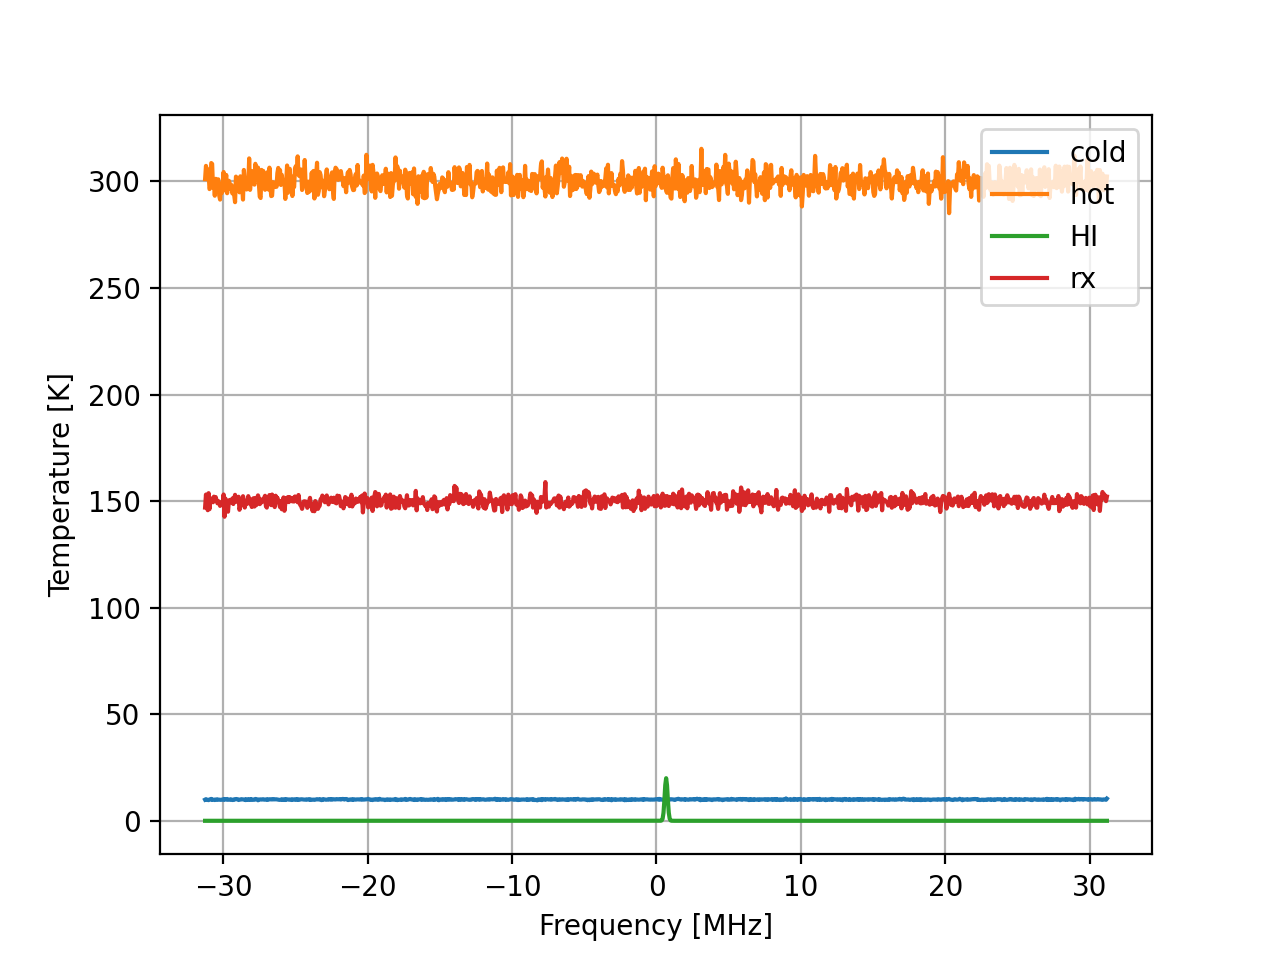

In [86]:
# Visualize mock 'true' signals
plt.figure()
for key,val in V.items():
    _d = np.fft.fft(val)
    pwr = np.average(np.abs(_d)**2, axis=0) / NSAMPLES
    plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label=key)
plt.legend()
plt.grid()
plt.xlabel('Frequency [MHz]')
_ = plt.ylabel('Temperature [K]')

# Generating the Measured Signals

Here, we combine the signal components defined above into measured voltages, applying an overall gain,
a differential gain between the real and imaginary components, and a bandpass function.

In [87]:
# Corrupt signal
V_meas = {
    'sky': V['rx'] + V['cold'] + V['HI'], # on-sky measurement
    'load': V['rx'] + V['hot'], # load-only measurement, assuming no sky
    'inj': V['rx'] + V['cold'] + V['HI'] + V['hot'], # injected measurement, assuming load adds to sky
}

for key,val in V_meas.items():
    val.shape = (val.shape[0], -1, bandpass.size)
    _val = np.fft.fft(val)
    _val *= bandpass
    val = np.fft.ifft(_val)
    val.shape = (val.shape[0], -1)
    val *= G_true
    val.real *= G_real
    val.imag *= G_imag
    
    V_meas[key] = val

<IPython.core.display.Javascript object>


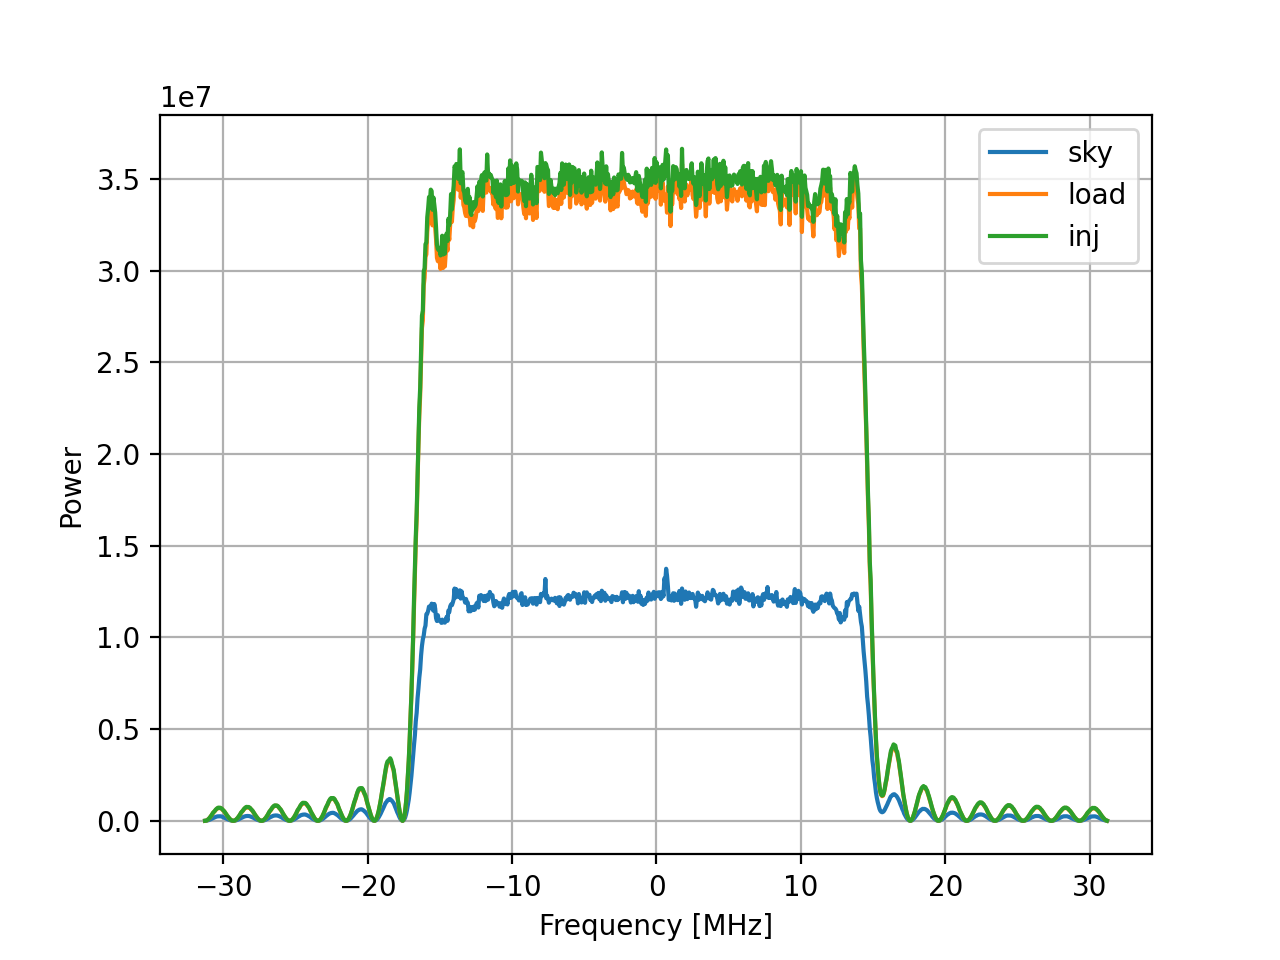

In [88]:
# Visualize mock 'true' signals
plt.figure()
for key,val in V_meas.items():
    _d = np.fft.fft(val)
    pwr = np.average(np.abs(_d)**2, axis=0) / NSAMPLES
    plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label=key)
plt.legend()
plt.grid()
plt.xlabel('Frequency [MHz]')
_ = plt.ylabel('Power')

# Calibration Examples

Here, we demonstrate a couple of different options for calibration.

### Wrong Attempts 1 and 2

First, let's demonstrate some pitfalls. The following two attempts at calibration do not average over time, so that random scatter in measured spectra is imprinted on the calculated gain, which is then transfered onto the calibrated spectrum.

In addition to the lack of averaging, the gains below are calculated using different approximations.
\begin{aligned}
G &\approx (T_{\rm hot} - T_{\rm cold}) / (P_{\rm load} - P_{\rm sky})\\
\end{aligned}
where 
\begin{aligned}
T_{\rm load}&= T_{\rm rx} + T_{\rm hot}\\
T_{\rm sky} &= T_{\rm rx} + T_{\rm cold} + T_{\rm HI}\\
T_{\rm inj} &= T_{\rm rx} + T_{\rm cold} + T_{\rm HI} + T_{\rm hot}\\
\end{aligned}
and in all cases, $T_i=G_i\cdot P_{\rm sky} - T_{\rm rx,i}$. We also estimate
\begin{equation}
T_{\rm rx,i} \approx \langle G_i\cdot P_{\rm sky}\rangle_t
\end{equation}

In [89]:
# Calculate averaged power spectra for each measurement
P = {key: np.abs(np.fft.fft(val))**2 for key,val in V_meas.items()}
fitband = np.abs(freqs[0]) < 8

# *Incorrect* Calibrations because they do not average
G_wrong = (T['hot'] - T['cold']) / (P['load'] - P['sky']) # note the lack of averaging
Tsky_wrong = np.mean(G_wrong * P['sky'], axis=0) # averaged, but only after a noisy gain is applied
Trx_wrong1 = np.mean(G_wrong * P['sky'], axis=0) # averaged over time, but only after a noisy gain is applied
Trx_true = T['rx']

<IPython.core.display.Javascript object>


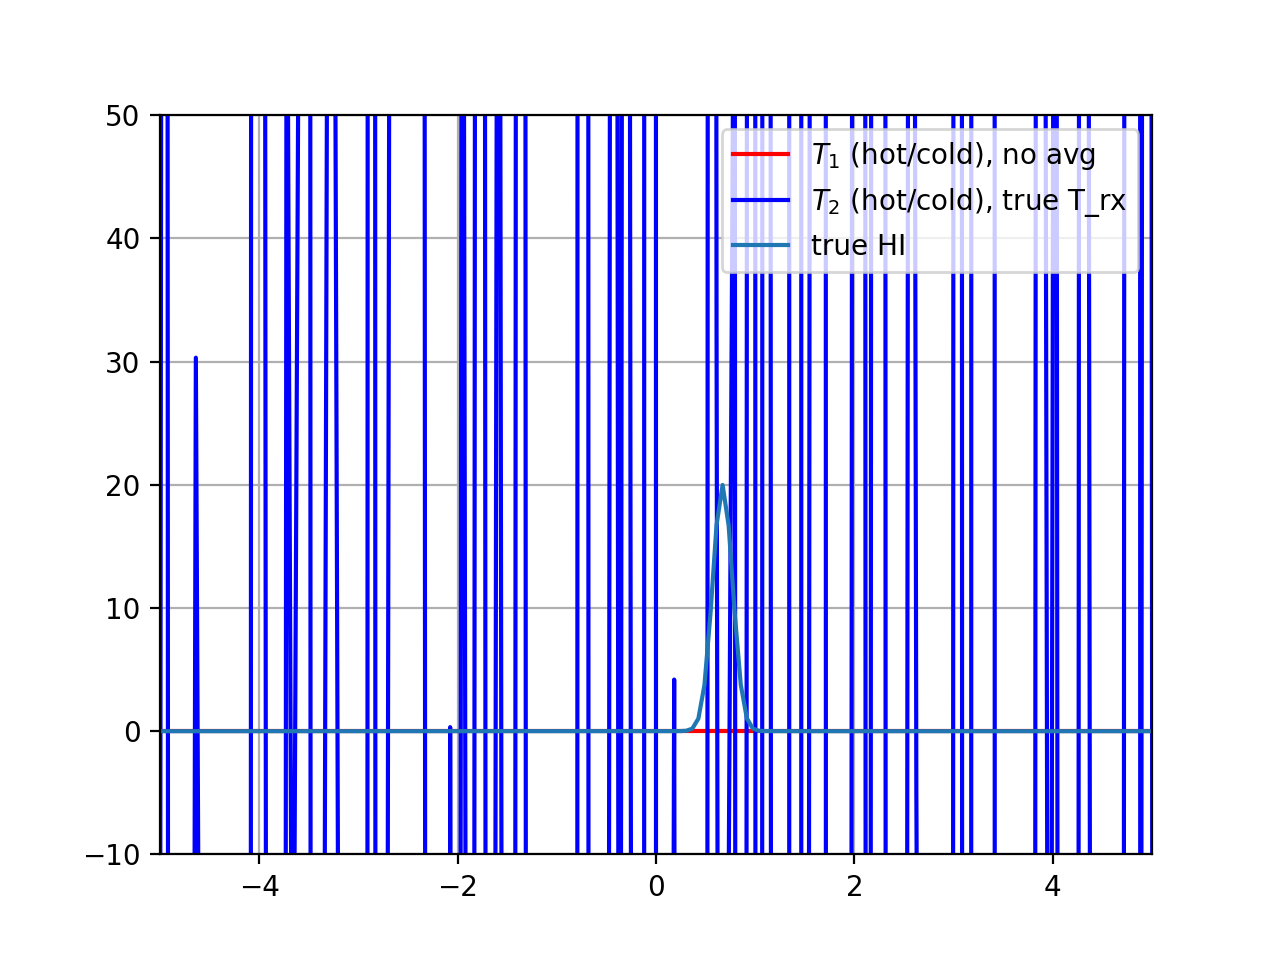

In [90]:
plt.figure()
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(Tsky_wrong - Trx_wrong1),
         'r-', label='$T_1$ (hot/cold), no avg')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(Tsky_wrong - T['rx']),
         'b-', label='$T_2$ (hot/cold), true T_rx')
pwr = np.average(np.abs(np.fft.fft(V['HI']))**2, axis=0) / NSAMPLES
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label='true HI')
plt.legend()
plt.ylim(-10, 50)
plt.xlim(-5, 5)
_ = plt.grid()

Notice that $T_1$ is uniformly zero. Why? Because our computation of $T_{\rm rx}$ without averaging looked exactly like the sky spectrum. We gave G and $T_{\rm rx}$ so many degrees of freedom, it ate up all of our signal!

But even if we substitute the true value of $T_{\rm rx}$ (as in $T_2$), there is so much scatter, we can't see the HI line. That is a result of failing to average $G$.

### Better (but Still Wrong) Attempts 3 and 4

In our next two attempts, we will average the gain over time to reduce scatter.
The gains below are calculated using different approximations.
\begin{aligned}
G_3 &\approx (T_{\rm hot} - T_{\rm cold}) / \langle P_{\rm load} - P_{\rm sky}\rangle_t\\
G_4 &\approx T_{\rm hot} / \langle P_{\rm inj} - P_{\rm sky}\rangle_t\\
\end{aligned}
where $\langle\dots\rangle_t$ denotes an average over time. 

<IPython.core.display.Javascript object>


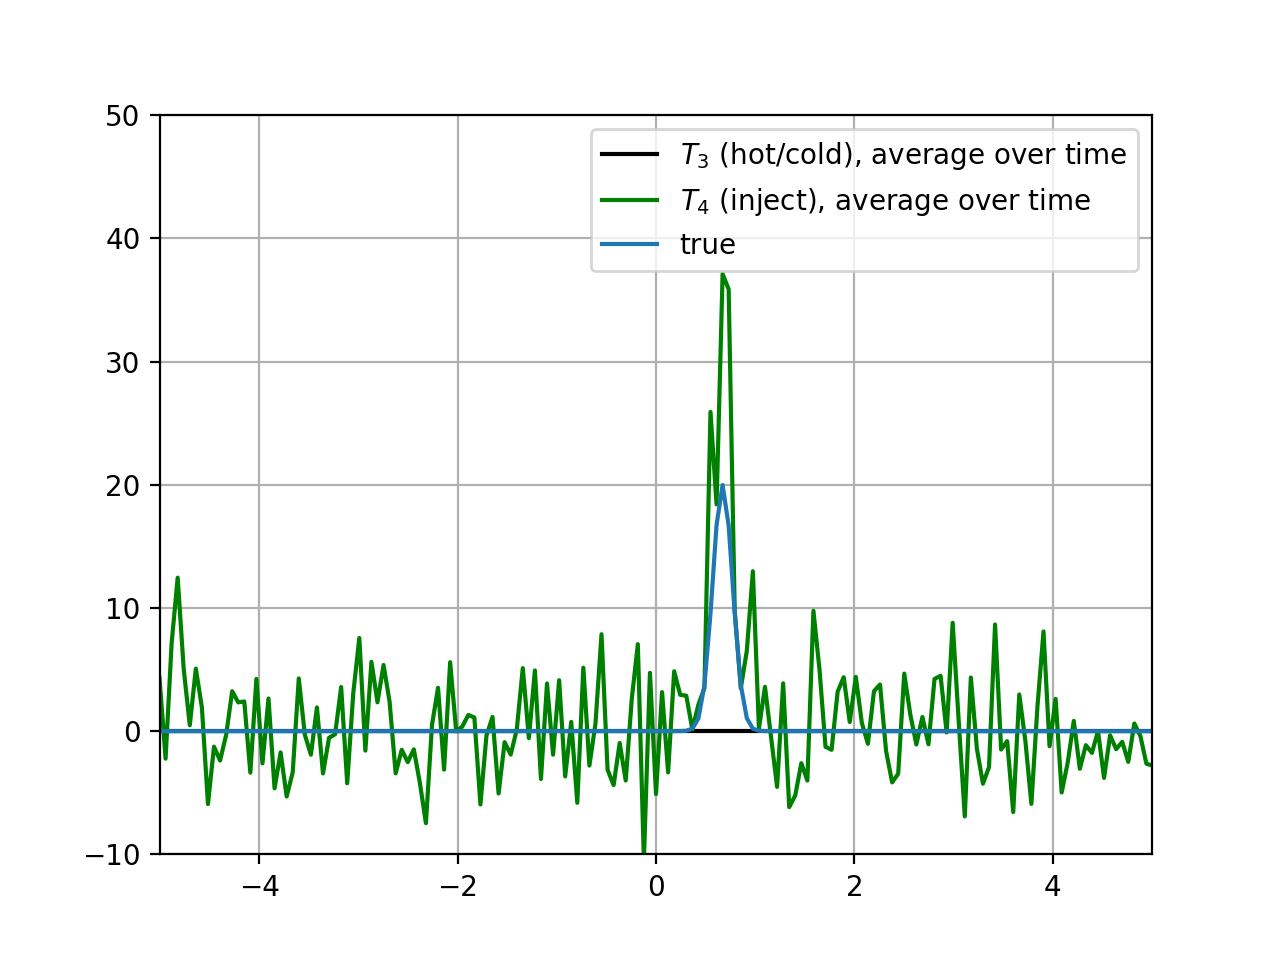

In [91]:
# These calibrations are better (but still wrong) because they average across time
G_better = (T['hot'] - T['cold']) / np.mean(P['load'] - P['sky'], axis=0) # averaged over time
Trx_better3 = np.mean(G_better * P['sky'], axis=0)
Trx_better4 = np.mean(G_better * P['sky'])

plt.figure()
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better * np.mean(P['sky'], axis=0) - Trx_better3),
         'k-', label='$T_3$ (hot/cold), average over time')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better * np.mean(P['sky'], axis=0) - Trx_better4),
         'g-', label='$T_4$ (inject), average over time')
pwr = np.average(np.abs(np.fft.fft(V['HI']))**2, axis=0) / NSAMPLES
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label='true')
plt.legend()
plt.ylim(-10,50)
plt.xlim(-5,5)
_ = plt.grid()

Despite our efforts, $T_3$ is uniformly zero again. Why? Because even though we averaged over time, when we compute $T_{\rm rx,i}$ in each channel of our spectrum, we still subtract off the exact value that we got averaging with the gain multiplied in (the gain just factors out). So no good.

In $T_4$, where we average $T_{\rm rx,i}$ over frequency too, and we observe that the scatter has been dramatically reduced (good!). But there is still a lot of scatter. We should average $G$ over frequency too.

### Even Better (but Still Slightly Wrong) Attempts 5 and 6

In this example, we average $G$ and $T_{\rm rx}$ over time and frequency. We do, however, explore the assumption of whether the injected signal adds to the temperature, or replaces it.
\begin{aligned}
G_5 &\approx (T_{\rm hot} - T_{\rm cold}) / \langle P_{\rm load} - P_{\rm sky}\rangle_{t,f}\\
G_6 &\approx T_{\rm hot} / \langle P_{\rm inj} - P_{\rm sky}\rangle_{t,f}\\
\end{aligned}
where $\langle\dots\rangle_{t,f}$ denotes an average over time and frequency.

<IPython.core.display.Javascript object>


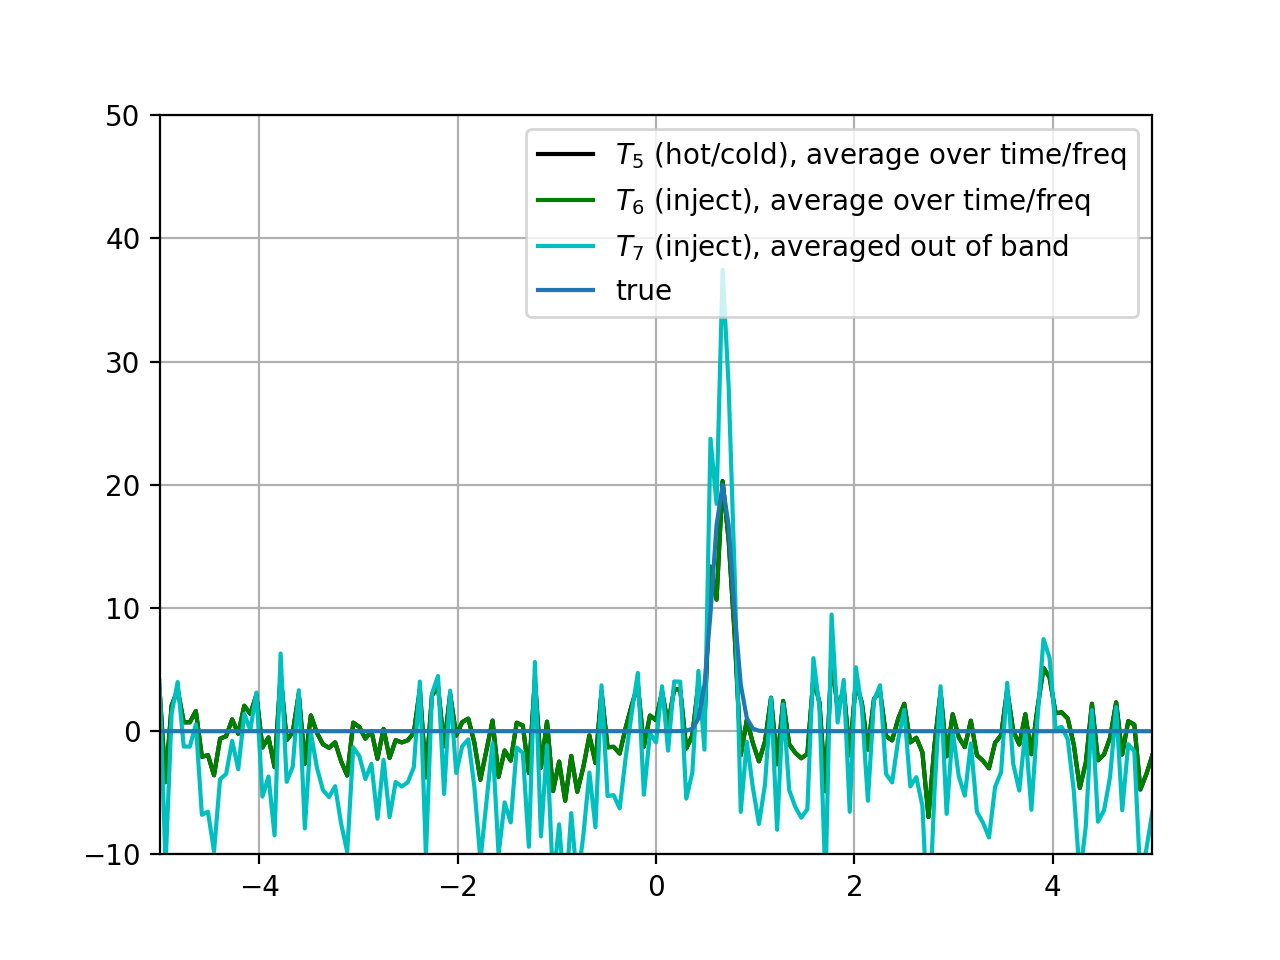

In [92]:
# These calibrations are better (but still imperfect) because they average across both
# time and frequency.
G_better5 = (T['hot'] - T['cold']) / np.mean(P['load'][:,fitband] - P['sky'][:,fitband]) # averaged over t,f
G_better6 = (T['hot']) / np.mean(P['inj'][:,fitband] - P['sky'][:,fitband]) # averaged over t,f
G_better7 = (T['hot']) / np.mean(P['inj'] - P['sky']) # averaged over t,f
Trx_better5 = np.mean(G_better5 * P['sky'][:,fitband])
Trx_better6 = np.mean(G_better6 * P['sky'][:,fitband])
Trx_better7 = np.mean(G_better7 * P['sky'])

plt.figure()
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better5 * np.mean(P['sky'], axis=0) - Trx_better5),
         'k-', label='$T_5$ (hot/cold), average over time/freq')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better6 * np.mean(P['sky'], axis=0) - Trx_better6),
         'g-', label='$T_6$ (inject), average over time/freq')
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(G_better7 * np.mean(P['sky'], axis=0) - 2*Trx_better7),
         'c-', label='$T_7$ (inject), averaged out of band')
pwr = np.average(np.abs(np.fft.fft(V['HI']))**2, axis=0) / NSAMPLES
plt.plot(np.fft.fftshift(freqs[0]), np.fft.fftshift(pwr), label='true')
plt.legend()
plt.ylim(-10,50)
plt.xlim(-5,5)
_ = plt.grid()

Averaging over frequency reduced the scatter even more. We have effectively eliminated the scatter that comes from the gain calibration, although some still remains because the average power spectrum itself has scatter. Averaging assuming HI is zero ($T_5$ vs. $T_6$ above) doesn't change much because we've amortized that error over the whole band.

The only caution is in $T_7$, which averaged over the *whole* band, not just the middle of the band where $G$ is constant. This results in a misestimation of G.